In [1]:
using Pkg: Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

import MathOptInterface as MOI
using Ipopt: Ipopt
import ForwardDiff as FD
import Convex as cvx
using ECOS: ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc
using Printf

  Activating environment at `~/Desktop/16-745 OCRL/16745-Optimal-Control-and-RL/HW3_S24-main/Project.toml`
Precompiling project...
  ✓ TranscodingStreams
  ✓ CodecZlib
  ✓ CodecBzip2
  ✓ HTTP
  ✓ GR
  ✓ MeshCat
  ✓ JLD2
  ✓ MathOptInterface
  ✓ ECOS
  ✓ Plots
  ✓ Convex
  ✓ Ipopt
  12 dependencies successfully precompiled in 65 seconds (195 already precompiled)


# Q2: iLQR (30 pts)

In this problem, we are going to use iLQR to solve a trajectory optimization for a 6DOF quadrotor. This problem we will use a cost function to motivate the quadrotor to follow a specified aerobatic manuever. The continuous time dynamics of the quadrotor are detailed in `quadrotor.jl`, with the state being the following:

$ x = [r,v,{}^Np^B{},\omega] $ where $r\in\mathbb{R}^3$ is the position of the quadrotor in the world frame (N), $v\in\mathbb{R}^3$ is the velocity of the quadrotor in the world frame (N),  $^Np^B\in\mathbb{R}^3$ is the Modified Rodrigues Parameter (MRP) that is used to denote the attitude of the quadrotor, and  $\omega\in\mathbb{R}^3$ is the angular velocity of the quadrotor expressed in the body frame (B).  By denoting the attitude of the quadrotor with a MRP instead of a quaternion or rotation matrix, we have to be careful to avoid any scenarios where the MRP will approach it's singularity at 360 degrees of rotation. For the manuever planned in this problem, the MRP will be sufficient. 

The dynamics of the quadrotor are discretized with `rk4`, resulting in the following discrete time dynamics function:

In [2]:
include(joinpath(@__DIR__, "utils", "quadrotor.jl"))

function discrete_dynamics(params::NamedTuple, x::Vector, u, k)
	# discrete dynamics
	# x - state 
	# u - control 
	# k - index of trajectory 
	# dt comes from params.model.dt 
	return rk4(params.model, quadrotor_dynamics, x, u, params.model.dt)
end


discrete_dynamics (generic function with 1 method)

## Part A: iLQR for a quadrotor (25 pts)

iLQR is used to solve optimal control problems of the following form:
$$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & \bigg[ \sum_{i=1}^{N-1} \ell(x_i,u_i)\bigg] + \ell_N(x_N)\\ 
 \text{st} \quad & x_1 = x_{{IC}} \\ 
 & x_{k+1} = f(x_k, u_k) \quad \text{for } i = 1,2,\ldots,N-1 \\
 \end{align}$$
 where $x_{IC}$ is the inital condition, $x_{k+1} = f(x_k, u_k)$ is the discrete dynamics function, $\ell(x_i,u_i)$ is the stage cost, and $\ell_N(x_N)$ is the terminal cost.  Since this optimization problem can be non-convex, there is no guarantee of convergence to a global optimum, or even convergene rates to a local optimum, but in practice we will see that it can work very well. 
 
For this problem, we are going to use a simple cost function consisting of the following stage cost:

$$ \ell(x_i,u_i) = \frac{1}{2} (x_i - x_{ref,i})^TQ(x_i - x_{ref,i}) + \frac{1}{2}(u_i - u_{ref,i})^TR(u_i - u_{ref,i}) $$

And the following terminal cost:

$$ \ell_N(x_N) = \frac{1}{2}(x_N - x_{ref,N})^TQ_f(x_N - x_{ref,N}) $$

This is how we will encourange our quadrotor to track a reference trajectory $x_{ref}$. In the following sections, you will implement `iLQR` and use it inside of a `solve_quadrotor_trajectory` function. Below we have included some starter code, but you are free to use/not use any of the provided functions so long as you pass the tests. 

We will consider iLQR to have converged when $\Delta J < \text{atol}$ as calculated during the backwards pass. 

In [3]:
# starter code: feel free to use or not use 

function stage_cost(p::NamedTuple, x::Vector, u::Vector, k::Int)
	"""
		NOTE: x here has been the one state in the trajectory X
	"""
	# TODO: return stage cost at time step k 
	Q, R, X_ref, U_ref = p.Q, p.R, p.Xref[k], p.Uref[k]
	stage_cost_k = 0.5 * (x - X_ref)' * Q * (x - X_ref) + 0.5 * (u - U_ref)' * R * (u - U_ref)
	return stage_cost_k
end

function term_cost(p::NamedTuple, x)
	# TODO: return terminal cost
	Qf, X_ref = p.Qf, p.Xref[end]
	terminal_cost = 0.5 * (x - X_ref)' * Qf * (x - X_ref)
	return terminal_cost
end

function stage_cost_expansion(p::NamedTuple, x::Vector, u::Vector, k::Int)
	# TODO: return stage cost expansion
	# if the stage cost is J(x,u), you can return the following
	# ∇ₓ²J, ∇ₓJ, ∇ᵤ²J, ∇ᵤJ
	Q, R, X_ref, U_ref = p.Q, p.R, p.Xref[k], p.Uref[k]

	∇ₓ²J = Q
	∇ₓJ = Q * (x - X_ref)

	∇ᵤ²J = R
	∇ᵤJ = R * (u - U_ref)

	return ∇ₓ²J, ∇ₓJ, ∇ᵤ²J, ∇ᵤJ
end

function term_cost_expansion(p::NamedTuple, x::Vector)
	# TODO: return terminal cost expansion
	# if the terminal cost is Jn(x,u), you can return the following
	# ∇ₓ²Jn, ∇ₓJn
	Qf, X_ref = p.Qf, p.Xref[end]

	∇ₓ²Jn = Qf
	∇ₓJn = Qf * (x - X_ref)

	return ∇ₓ²Jn, ∇ₓJn
end


function trajectory_cost(params::NamedTuple,          # useful params 
	X::Vector{Vector{Float64}},  # state trajectory 
	U::Vector{Vector{Float64}},   # control trajectory 
)
	# compute the trajectory cost for trajectory X and U (assuming they are dynamically feasible)
	N = params.N

	# TODO: add trajectory cost 
	total_cost = 0.0
	for k ∈ 1:N-1
		total_cost += stage_cost(params, X[k], U[k], k)
	end
	total_cost += term_cost(params, X[N])

	return total_cost
end

trajectory_cost (generic function with 1 method)

In [4]:
function backward_pass(params::NamedTuple,          # useful params 
	X::Vector{Vector{Float64}},  # state trajectory 
	U::Vector{Vector{Float64}},  # control trajectory 
)
	# compute the iLQR backwards pass given a dynamically feasible trajectory X and U
	# return d, K, ΔJ  

	# outputs:
	#     d  - Vector{Vector} feedforward control  
	#     K  - Vector{Matrix} feedback gains 
	#     ΔJ - Float64        expected decrease in cost 

	nx, nu, N = params.nx, params.nu, params.N

	# vectors of vectors/matrices for recursion 
	P = [zeros(nx, nx) for i ∈ 1:N]   # cost to go quadratic term: 	PN = (ℓN)xx + (cN)x' IμN (cN)x. 
	p = [zeros(nx) for i ∈ 1:N]   # cost to go linear term: 		pN = (ℓN)x + (cN)x' (λ + IμN cN)
	d = [zeros(nu) for i ∈ 1:N-1] # feedforward control
	K = [zeros(nu, nx) for i ∈ 1:N-1] # feedback gain

	# TODO: implement backwards pass and return d, K, ΔJ 
	N = params.N
	ΔJ = 0.0

	_∇ₓ²Jn, _∇ₓJn = term_cost_expansion(params, X[end])
	P[N], p[N] = _∇ₓ²Jn, _∇ₓJn

	for k ∈ N-1:-1:1
		_∇ₓ²J, _∇ₓJ, _∇ᵤ²J, _∇ᵤJ = stage_cost_expansion(params, X[k], U[k], k)
		A = FD.jacobian(x -> discrete_dynamics(params, x, U[k], k), X[k])
		B = FD.jacobian(u -> discrete_dynamics(params, X[k], u, k), U[k])

		Qxx = _∇ₓ²J + A' * P[k+1] * A
		Quu = _∇ᵤ²J + B' * P[k+1] * B
		Qux = B' * P[k+1] * A
		# Qxu = Qux'
		Qxu = A' * P[k+1] * B

		@assert isapprox(P[k+1], P[k+1]')
		@assert isapprox(Qxu, Qux')

		Qx = _∇ₓJ + A' * p[k+1]
		Qu = _∇ᵤJ + B' * p[k+1]

		# Compute feedback gain K and feedforward term d
		K[k] = -Quu \ Qux
		d[k] = -Quu \ Qu

		# Update P and p for the next iteration
		# =========================================
		# === Bugs: Qux' could not replace Qxu ====
		# =========================================
		P[k] = Qxx + (K[k]' * Quu * K[k]) + (K[k]' * Qux) + (Qxu * K[k])
		p[k] = Qx + (K[k]' * Quu * d[k]) + (K[k]' * Qu) + (Qxu * d[k])

		# Update the expected cost decrease
		# @ref: 
		#	https://studywolf.wordpress.com/2016/02/03/the-iterative-linear-quadratic-regulator-method/
		#	https://zhuanlan.zhihu.com/p/660810899?utm_psn=1695796371687419904
		#	http://rail.eecs.berkeley.edu/deeprlcourse/static/slides/lec-10.pdf
		ΔJ -= (d[k]' * Qu) + (0.5 * d[k]' * Quu * d[k])
	end

	return d, K, ΔJ
end


function forward_pass(params::NamedTuple,           # useful params 
	X::Vector{Vector{Float64}},   # state trajectory (r: position; v: velocity, p: mrp,attitude, w: angular velocity)
	U::Vector{Vector{Float64}},   # control trajectory 
	d::Vector{Vector{Float64}},   # feedforward controls 
	K::Vector{Matrix{Float64}};   # feedback gains
	max_linesearch_iters = 20,   # max iters on linesearch 
)
	# forward pass in iLQR with linesearch 
	# use a line search where the trajectory cost simply has to decrease (no Armijo)

	# outputs:
	#     Xn::Vector{Vector}  updated state trajectory  
	#     Un::Vector{Vector}  updated control trajectory 
	#     J::Float64          updated cost  
	#     α::Float64.         step length 

	nx, nu, N = params.nx, params.nu, params.N

	Xn = [zeros(nx) for i ∈ 1:N]      # new state history 
	Un = [zeros(nu) for i ∈ 1:N-1]    # new control history 

	# initial condition 
	Xn[1] = 1 * X[1]

	# initial step length 
	α = 1.0

	# TODO: add forward pass 
	for i ∈ 1:max_linesearch_iters
		for k ∈ 1:N-1
			Un[k] = U[k] + α * d[k] + K[k] * (Xn[k] - X[k])
			Xn[k+1] = discrete_dynamics(params, Xn[k], Un[k], k)
		end

		Jn = trajectory_cost(params, Xn, Un)
		if Jn < trajectory_cost(params, X, U)
			return Xn, Un, Jn, α
		end

		α /= 2
	end

	error("forward pass failed")
end


forward_pass (generic function with 1 method)

In [5]:
function iLQR(params::NamedTuple,         # useful params for costs/dynamics/indexing 
	x0::Vector,                 # initial condition (r: position; v: velocity, p: mrp,attitude, w: angular velocity)
	U::Vector{Vector{Float64}}; # initial controls 
	atol = 1e-3,                  # convergence criteria: ΔJ < atol 
	max_iters = 250,            # max iLQR iterations 
	verbose = true)             # print logging

	# iLQR solver given an initial condition x0, initial controls U, and a dynamics function described by `discrete_dynamics`

	# return (X, U, K) where 
	# outputs:
	#     X::Vector{Vector} - state trajectory 
	#     U::Vector{Vector} - control trajectory 
	#     K::Vector{Matrix} - feedback gains K 

	# iLQR is a Trajectory Optimization algorithm, with non-convex cost functions and non-linear dynamics.
	# Iteratively apply LQR for a sequence of time steps:
	# Approximate non-convex cost functions using second order Taylor expansion into a quadratic form
	# Approximate non-linear dynamics using first order Taylor expansion into a linear form

	# 1. Backward pass: compute the feedforward control d and feedback gains K
	# 2. Forward pass: apply the d and K to get a new trajectory x, u

	# @ref: https://rexlab.ri.cmu.edu/papers/iLQR_Tutorial.pdf
	# @ref: https://bjack205.github.io/papers/AL_iLQR_Tutorial.pdf

	# first check the sizes of everything
	@assert length(U) == params.N - 1
	@assert length(U[1]) == params.nu
	@assert length(x0) == params.nx

	nx, nu, N = params.nx, params.nu, params.N # 12, 4, 100

	# TODO: initial rollout: J ← trajectory_cost(X, U)
	X = [zeros(nx) for i ∈ 1:N]

	X[1] = copy(x0)
	for k ∈ 1:N-1
		X[k+1] = discrete_dynamics(params, X[k], U[k], k)
	end

	J = trajectory_cost(params, X, U)

	for ilqr_iter ∈ 1:max_iters
		"""
			J` ← J; 
			K, d, ΔV ← BACKWARDPASS(X, U);
			X, U, J ← FORWARDPASS(X, U, d, K, ΔV, J`);
		"""
		d, K, ΔJ = backward_pass(params, X, U)
		X, U, J, α = forward_pass(params, X, U, d, K)

		# termination criteria 
		if ΔJ < atol
			if verbose
				@info "iLQR converged"
			end
			return X, U, K
		end

		# ---------------logging -------------------
		if verbose
			dmax = maximum(norm.(d))
			if rem(ilqr_iter - 1, 10) == 0
				@printf "iter     J           ΔJ        |d|         α         \n"
				@printf "-------------------------------------------------\n"
			end
			@printf("%3d   %10.3e  %9.2e  %9.2e  %6.4f    \n",
				ilqr_iter, J, ΔJ, dmax, α)
		end
	end
	error("iLQR failed")
end


iLQR (generic function with 1 method)

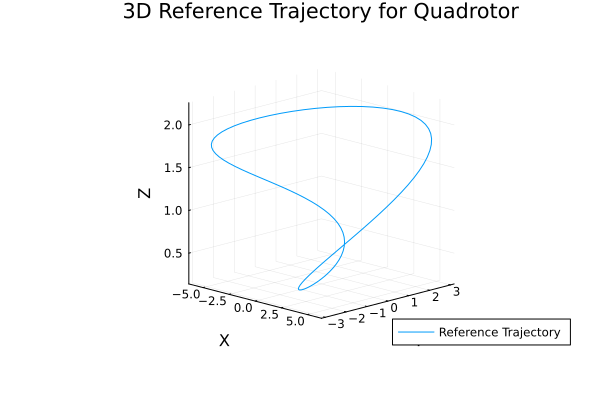

length(Xref) = 100
length(Uref) = 99


solve_quadrotor_trajectory (generic function with 1 method)

In [6]:
function create_reference(N, dt)
	# create reference trajectory for quadrotor 
	R = 6
	Xref = [
		[R * cos(t); R * cos(t) * sin(t); 1.2 + sin(t); zeros(9)]
		for t ∈ range(-pi / 2, 3 * pi / 2, length = N)
	]

	for i ∈ 1:(N-1)
		Xref[i][4:6] = (Xref[i+1][1:3] - Xref[i][1:3]) / dt
	end

	Xref[N][4:6] = Xref[N-1][4:6]

	Uref = [(9.81 * 0.5 / 4) * ones(4) for i ∈ 1:(N-1)]

	return Xref, Uref
end

Xref, Uref = create_reference(100, 0.05)

x_positions = [Xref[i][1] for i in 1:length(Xref)]
y_positions = [Xref[i][2] for i in 1:length(Xref)]
z_positions = [Xref[i][3] for i in 1:length(Xref)]

display(plot3d(
	x_positions, y_positions, z_positions, label = "Reference Trajectory ", xlabel = "X", ylabel = "Y", zlabel = "Z",
	title = "3D Reference Trajectory for Quadrotor",
	legend = :bottomright,
	camera = (45, 15, 2),  # adjust the azimuth, elevation, and distance
))
@show length(Xref);
# @show Xref;
@show length(Uref);
# @show Uref;

function solve_quadrotor_trajectory(; verbose = true)
	# problem size 
	nx = 12
	nu = 4
	dt = 0.05
	tf = 5
	t_vec = 0:dt:tf
	N = length(t_vec) # number of time steps, 100

	# create reference trajectory 
	Xref, Uref = create_reference(N, dt)

	# tracking cost function
	# Q: 
	# [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
	#  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
	#  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
	#  [0, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0],
	#  [0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0],
	#  [0, 0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0, 0],
	#  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
	#  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
	#  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
	#  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0],
	#  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0],
	#  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1]]
	Q = 1 * diagm([1 * ones(3); 0.1 * ones(3); 1 * ones(3); 0.1 * ones(3)])

	# R:
	# [[0.1, 0, 0, 0],
	#  [0, 0.1, 0, 0],
	#  [0, 0, 0.1, 0],
	#  [0, 0, 0, 0.1]]
	R = 0.1 * diagm(ones(nu))
	Qf = 10 * Q

	# dynamics parameters (these are estimated)
	model = (mass = 0.5,
		J = Diagonal([0.0023, 0.0023, 0.004]),
		gravity = [0, 0, -9.81],
		L = 0.1750,
		kf = 1.0, km = 0.0245,
		dt = dt)

	# the params needed by iLQR 
	params = (N = N, nx = nx, nu = nu,
		Xref = Xref, Uref = Uref,
		Q = Q, R = R, Qf = Qf,
		model = model)

	# initial condition 
	x0 = 1 * Xref[1]

	# initial guess controls 
	U = [(uref + 0.0001 * randn(nu)) for uref in Uref]

	# solve with iLQR
	X, U, K = iLQR(params, x0, U; atol = 1e-4, max_iters = 250, verbose = verbose)

	return X, U, K, t_vec, params
end


iter     J           ΔJ        |d|         α         
-------------------------------------------------
  1    2.987e+02   6.80e+04   2.85e+01  1.0000    
  2    1.072e+02   2.65e+02   1.35e+01  0.5000    
  3    4.899e+01   6.62e+01   4.73e+00  1.0000    
  4    4.429e+01   5.69e+00   2.47e+00  1.0000    
  5    4.402e+01   4.03e-01   2.51e-01  1.0000    
  6    4.398e+01   7.28e-02   8.53e-02  1.0000    
  7    4.396e+01   1.92e-02   7.37e-02  1.0000    
  8    4.396e+01   6.58e-03   3.82e-02  1.0000    
  9    4.396e+01   2.61e-03   3.26e-02  1.0000    
 10    4.396e+01   1.19e-03   1.99e-02  1.0000    
iter     J           ΔJ        |d|         α         
-------------------------------------------------
 11    4.396e+01   5.97e-04   1.65e-02  1.0000    
 12    4.395e+01   3.29e-04   1.12e-02  1.0000    
 13    4.395e+01   1.93e-04   9.21e-03  1.0000    
 14    4.395e+01   1.19e-04   6.83e-03  1.0000    


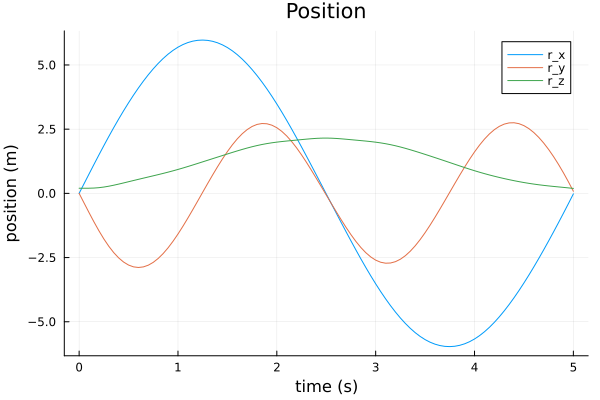

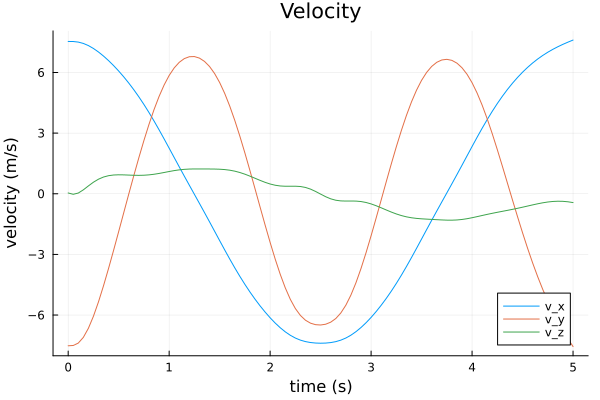

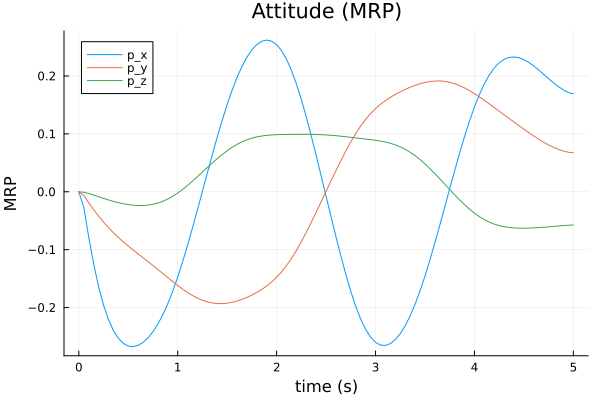

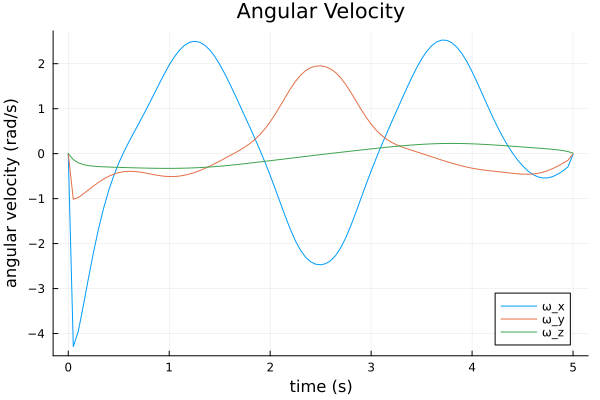

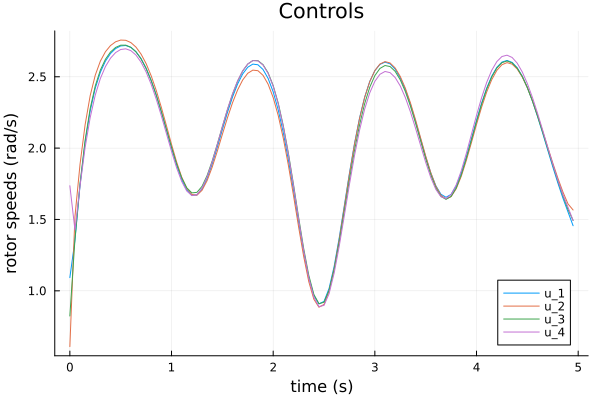

┌ Info: iLQR converged
└ @ Main /Users/guosiqi/Desktop/16-745 OCRL/16745-Optimal-Control-and-RL/HW3_S24-main/Q2.ipynb:56


Animating ...


┌ Info: Listening on: 127.0.0.1:8767, thread id: 1
└ @ HTTP.Servers /Users/guosiqi/.julia/packages/HTTP/sJD5V/src/Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8767
└ @ MeshCat /Users/guosiqi/.julia/packages/MeshCat/0RCA3/src/visualizer.jl:64


Animating 1 ...
Animating 2 ...
Animating 3 ...
Animating 4 ...
Test Summary: | Pass  Total
ilqr          |    1      1


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("traj" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("p94" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s14" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x31, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s44" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x34, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s52" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x35, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p92" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p98" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x38], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x36], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p23" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x32, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p90" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x30], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s94" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x39, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}())…)), "vic" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x76, 0x69, 0x63], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "target" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x74, 0x2f, 0x74, 0x61, 0x72, 0x67, 0x65, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8767, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8767), "127.0.0.

Test.DefaultTestSet("ilqr", Any[], 1, false, false)

In [7]:
@testset "ilqr" begin

	# NOTE: set verbose to true here when you submit
	Xilqr, Uilqr, Kilqr, t_vec, params = solve_quadrotor_trajectory(verbose = true)

	# ---------------testing------------------
	Usol = load(joinpath(@__DIR__, "utils", "ilqr_U.jld2"))["Usol"]
	@test maximum(norm.(Usol .- Uilqr, Inf)) <= 1e-2

	# ---------------plotting------------------
	Xm = hcat(Xilqr...)
	Um = hcat(Uilqr...)
	display(plot(t_vec, Xm[1:3, :]', xlabel = "time (s)", ylabel = "position (m)",
		title = "Position", label = ["r_x" "r_y" "r_z"]))

	display(plot(t_vec, Xm[4:6, :]', xlabel = "time (s)", ylabel = "velocity (m/s)",
		title = "Velocity", label = ["v_x" "v_y" "v_z"]))

	display(plot(t_vec, Xm[7:9, :]', xlabel = "time (s)", ylabel = "MRP",
		title = "Attitude (MRP)", label = ["p_x" "p_y" "p_z"]))

	display(plot(t_vec, Xm[10:12, :]', xlabel = "time (s)", ylabel = "angular velocity (rad/s)",
		title = "Angular Velocity", label = ["ω_x" "ω_y" "ω_z"]))

	display(plot(t_vec[1:end-1], Um', xlabel = "time (s)", ylabel = "rotor speeds (rad/s)",
		title = "Controls", label = ["u_1" "u_2" "u_3" "u_4"]))

	display(animate_quadrotor(Xilqr, params.Xref, params.model.dt))
end


    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/Desktop/16-745 OCRL/16745-Optimal-Control-and-RL/HW3_S24-main/Project.toml`
  No Changes to `~/Desktop/16-745 OCRL/16745-Optimal-Control-and-RL/HW3_S24-main/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/16-745 OCRL/16745-Optimal-Control-and-RL/HW3_S24-main/Project.toml`
  No Changes to `~/Desktop/16-745 OCRL/16745-Optimal-Control-and-RL/HW3_S24-main/Manifest.toml`


iter     J           ΔJ        |d|         α         
-------------------------------------------------
  1    2.987e+02   6.80e+04   2.85e+01  1.0000    
  2    1.072e+02   2.65e+02   1.35e+01  0.5000    
  3    4.899e+01   6.62e+01   4.73e+00  1.0000    
  4    4.429e+01   5.69e+00   2.47e+00  1.0000    
  5    4.402e+01   4.03e-01   2.51e-01  1.0000    
  6    4.398e+01   7.28e-02   8.53e-02  1.0000    
  7    4.396e+01   1.92e-02   7.37e-02  1.0000    
  8    4.396e+01   6.58e-03   3.82e-02  1.0000    
  9    4.396e+01   2.61e-03   3.26e-02  1.0000    
 10    4.396e+01   1.19e-03   1.99e-02  1.0000    
iter     J           ΔJ        |d|         α         
-------------------------------------------------
 11    4.396e+01   5.97e-04   1.65e-02  1.0000    
 12    4.395e+01   3.29e-04   1.12e-02  1.0000    
 13    4.395e+01   1.93e-04   9.21e-03  1.0000    
 14    4.395e+01   1.19e-04   6.83e-03  1.0000    


┌ Info: iLQR converged
└ @ Main /Users/guosiqi/Desktop/16-745 OCRL/16745-Optimal-Control-and-RL/HW3_S24-main/Q2.ipynb:56
┌ Info: Saved animation to /Users/guosiqi/Desktop/16-745 OCRL/16745-Optimal-Control-and-RL/HW3_S24-main/quadrotor_animation.gif
└ @ Plots /Users/guosiqi/.julia/packages/Plots/du2dt/src/animation.jl:156


Plots.AnimatedGif("/Users/guosiqi/Desktop/16-745 OCRL/16745-Optimal-Control-and-RL/HW3_S24-main/quadrotor_animation.gif")
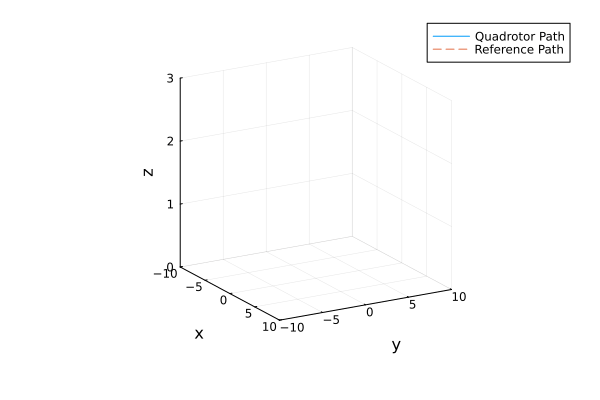

In [9]:
using Pkg
Pkg.add("Plots")
Pkg.add("GR")  # or "PlotlyJS"
using Plots
gr()  # or plotlyjs()

function _animate_quadrotor(X, Xref, dt; save_animation = false, filename = "quadrotor_animation.gif")
	nframes = length(X)

	anim = @animate for i in 1:nframes
		plot3d([X[j][1] for j in 1:i], [X[j][2] for j in 1:i], [X[j][3] for j in 1:i],
			xlabel = "x", ylabel = "y", zlabel = "z",
			xlims = (-10, 10), ylims = (-10, 10), zlims = (0, 3),
			label = "Quadrotor Path", legend = :topright, camera = (60, 18, 2))

		plot3d!([Xref[j][1] for j in 1:i], [Xref[j][2] for j in 1:i], [Xref[j][3] for j in 1:i],
			label = "Reference Path", legend = :topright, linestyle = :dash, camera = (60, 18, 2))
	end

	if save_animation
		gif(anim, filename, fps = 15)
	else
		display(anim)
	end
end

Xilqr, Uilqr, Kilqr, t_vec, params = solve_quadrotor_trajectory(verbose = true)
_animate_quadrotor(Xilqr, params.Xref, params.model.dt, save_animation = true)


## Part B: Tracking solution with TVLQR (5 pts)

Here we will do the same thing we did in Q1 where we take a trajectory from a trajectory optimization solver, and track it with TVLQR to account for some model mismatch. In DIRCOL, we had to explicitly compute the TVLQR control gains, but in iLQR, we get these same gains out of the algorithmn as the K's. Use these to track the quadrotor through this manuever. 

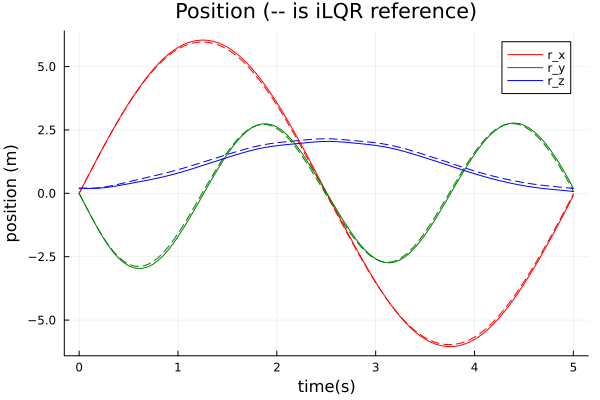

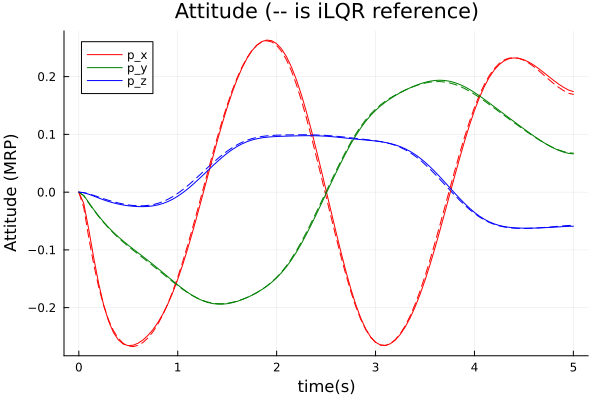

Animating ...
Animating 1 ...
Animating 2 ...
Animating 3 ...
Animating 4 ...


┌ Info: Listening on: 127.0.0.1:8768, thread id: 1
└ @ HTTP.Servers /Users/guosiqi/.julia/packages/HTTP/sJD5V/src/Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8768
└ @ MeshCat /Users/guosiqi/.julia/packages/MeshCat/0RCA3/src/visualizer.jl:64


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("traj" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("p94" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s14" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x31, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s44" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x34, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s52" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x35, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p92" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p98" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x38], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x36], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p23" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x32, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p90" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x30], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s94" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x39, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}())…)), "vic" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x76, 0x69, 0x63], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "target" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x74, 0x2f, 0x74, 0x61, 0x72, 0x67, 0x65, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8768, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8768), "127.0.0.

Test Summary:         | Pass  Total
iLQR with model error |    2      2


Test.DefaultTestSet("iLQR with model error", Any[], 2, false, false)

In [8]:
@testset "iLQR with model error" begin

	# set verbose to false when you submit 
	Xilqr, Uilqr, Kilqr, t_vec, params = solve_quadrotor_trajectory(verbose = false)

	# real model parameters for dynamics 
	model_real = (mass = 0.5,
		J = Diagonal([0.0025, 0.002, 0.0045]),
		gravity = [0, 0, -9.81],
		L = 0.1550,
		kf = 0.9,
		km = 0.0365, dt = 0.05)

	# simulate closed loop system 
	nx, nu, N = params.nx, params.nu, params.N
	Xsim = [zeros(nx) for i ∈ 1:N]
	Usim = [zeros(nx) for i ∈ 1:(N-1)]

	# initial condition 
	Xsim[1] = 1 * Xilqr[1]

	# TODO: simulate with closed loop control 
	for i ∈ 1:(N-1)
		# Correctly compute control input using feedback law
		# Equation: Usim = Uilqr - K * Δ
		Usim[i] = Uilqr[i] + Kilqr[i] * (Xsim[i] - Xilqr[i])

		# Update the state using the real dynamics and RK4 integration
		Xsim[i+1] = rk4(model_real, quadrotor_dynamics, Xsim[i], Usim[i], model_real.dt)

		# Check for numerical instability
		if any(isnan.(Xsim[i+1])) || any(abs.(Xsim[i+1]) .> 1e6)
			println("Simulation diverging at step $(i+1)")
			break
		end
	end


	# -----------------testing---------------------
	@test 1e-6 <= norm(Xilqr[50] - Xsim[50], Inf) <= 0.3
	@test 1e-6 <= norm(Xilqr[end] - Xsim[end], Inf) <= 0.3

	# -----------------plotting---------------------
	Xm = hcat(Xsim...)
	Um = hcat(Usim...)
	Xilqrm = hcat(Xilqr...)
	Uilqrm = hcat(Uilqr...)
	plot(t_vec, Xilqrm[1:3, :]', ls = :dash, label = "", lc = [:red :green :blue])
	display(plot!(t_vec, Xm[1:3, :]', title = "Position (-- is iLQR reference)",
		xlabel = "time(s)", ylabel = "position (m)",
		label = ["r_x" "r_y" "r_z"], lc = [:red :green :blue]))

	plot(t_vec, Xilqrm[7:9, :]', ls = :dash, label = "", lc = [:red :green :blue])
	display(plot!(t_vec, Xm[7:9, :]', title = "Attitude (-- is iLQR reference)",
		xlabel = "time(s)", ylabel = "Attitude (MRP)",
		label = ["p_x" "p_y" "p_z"], lc = [:red :green :blue]))

	display(animate_quadrotor(Xilqr, params.Xref, params.model.dt))
end
